# What is Sentiment Analysis?

Sentiment analysis is the process of detecting positive or negative sentiment in text. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers.


# Why do we do it?

Automatically analyzing customer feedback, such as opinions in survey responses and social media conversations, allows brands to learn what makes customers happy or frustrated, so that they can tailor products and services to meet their customers’ needs

### In this notebook, I try to breakdown and elucidate this magnificient task so that the true essence of this wonderful analysis is felt.

In [ ]:
## General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud ### For visualising the frequent words
import re
import random
import string
import math

# To mute general warnings
import warnings
warnings.filterwarnings('ignore')

## For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# When we are modeling a simple ML algorithms, we generally use 
# scikit-learn's CountVectorizer, etc...
# Else we use tensorflow's Tokeniser

# tf=TfidfVectorizer()
# cv_train=tf.fit_transform(train["text"]).toarray()
# cv_test=tf.transform(test["text"]).toarray()

## For building our Model
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Conv1D,Bidirectional,SpatialDropout1D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## For Text Processing:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker

In [ ]:
plt.style.use('fivethirtyeight')

## Data Inspection:

#### Reading the DataFrame

In [ ]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)
df.head()

#### Basic Info

In [ ]:
print(f"There are {df.shape[0]} ROWS and {df.shape[1]}")

#### The dataset contains **1.6 Million** Tweets and I find it a good amount of data to train our model.

In [ ]:
df.info()

In [ ]:
df.columns

#### Renaming the columns properly::

In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

##### Here "sentiment" is the target variable.

In [ ]:
df["sentiment"].value_counts()

In [ ]:
### For ease of testing and computation
df = df.groupby('sentiment').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

df.sentiment.value_counts()

#### Here,

##### **0** represents a Negative Sentiment

##### **4** represents a Positive Sentiment

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
df.sentiment = df.sentiment.apply(lambda x: lab_to_sentiment[x])
df.head()

In [ ]:
### Visualising the distribution of the target variable.
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Target Distribution")

#### There is no class imbalance.

#### Now let us explore the data we having here...

In [ ]:
### randomly selecting rows and printing them
ind=np.random.randint(0,1000,(10)) 
df.iloc[ind].text

#### Looks like we have so much to clean!

<div style="width:100%;text-align: center;"> <img align=middle src="https://sd.keepcalms.com/i/keep-calm-its-clean-up-time-1.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>

## Text Preprocessing:

- Tweets usually contain unnecessary data like **user mentions**, **hyperlink texts**, **emoticons** and **punctuations**. 

- In order to use text for learning, we need to clean them before training a model. 

### The following steps are going to be incorporated while cleaning::

### 1. Tokenisation - 

* Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning. 

* The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).

### 2. Stopwords - 

* Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words.

* The list of inbuilt stopwords has been displayed below. Here we try to remove negative words like "not", "doesn't", etc... from the original list of stopwords as these words really influnce the opinion of users and their sentiments.

### 3. Hyperlink Texts and Removals - 

* We are going to remove these using pattern detection and RegEx.

---> Twitter User Mentions - Eg. @sudhar, @andrewng

---> Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### 4. Punctuation Mark Removal - 

* We try to remove all punctuation marks as they contain no relevant information. We do it after step 3 as we wont be able to match with any pattern if done before.

### 5. Stemming/Lemmatization - 

* Lemmatization and Stemming are **Text Normalization** techniques. These techniques are used to prepare words, text, and documents for further processing.

* Lemmatization takes **more time**(**computationally expensive**) as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time. Hence Stemming is used in large datasets.

WordNetLemmatizer ---> Lemmatizing

SnowBallStemmer ---> Stemming

### 6. Spelling Correction - (Optional)

* In this notebook, I not used a Spell Checker. Its optional to the user. The python package **pyspellchecker** can be used for correcting spellings and I have provided an optional function which can be applied on the data frame.

In [ ]:
## Getting a list of stop words in English:
l_remove="don, don't, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't"
stop_words=[i for i in stopwords.words('english') if i not in l_remove.split(", ")]

#### Pattern removing Hyperlinks and Mentions:
pattern = "(@\S+)|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"

## List of Punctuation marks:
punct=string.punctuation

## Setting a Stemmer Object:
stemmer = SnowballStemmer('english')

## Function to remove numbers:
def remove_numb(text):
    return re.sub("[0-9]+","",text)

Optional Speller Function:

In [ ]:
### Function for spelling-checker:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    ## Checks whether the corrected string is None, meaning there is no proper 
    ## spelling available.
    ct=[i for i in corrected_text if i is not None]
    if " ".join(corrected_text):
        return text
    else:
        return " ".join(corrected_text)

##### Having a look at the different stopwords available under NLTK:

In [ ]:
### Stop words offered by NLTK:
", ".join(stopwords.words('english'))

In [ ]:
### Viewing the number of rows having MENTIONS:
v=[]
for i in df.text:
    v.append(re.findall(r'(@\S+)',i))   
    
v1=[i for i in v if len(i)!=0]
print(f"There are {len(v1)} rows with Mentions(@yyy) in their text")

In [ ]:
### Viewing the number of rows having HYPERLINKS:
v=[]
for i in df.text:
    v.append(re.findall(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])',i))   

v2=[i for i in v if len(i)!=0]
print(f"There are {len(v2)} rows with Hyperlinks(http://yyy) in their text")

In [ ]:
v1[:10]

In [ ]:
v2[:10]

In [ ]:
labels = ["Mentions","Hyperlinks"]
data = [len(v1),len(v2)]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(math.log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ["blue","yellow"]

#create figure, axis
fig, ax = plt.subplots(figsize=(5,5))
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

In [ ]:
def funct_clean(x,stem=False):
    ### Removing Mentions and Hyperlinks:
    sentence = re.sub(pattern, ' ', str(x).lower()).strip()
    ### Converting to lower case:
    sentence = sentence.lower()
    ### Removing punctuation marks:
    sentence=sentence.translate(str.maketrans('', '', punct))
    ### Tokenising:
    words = word_tokenize(sentence)
    tokens = []
    for token in words:
        if token not in stop_words:   ### Checking whether the token is a stop word
            if stem:
                tokens.append(stemmer.stem(token))  ### Stemming the token(Less time taken)
            else:
                tokens.append(token)
    
    ## Removing numbers
    t1=remove_numb(" ".join(tokens)).split()
    ## can include the speller function while returning
    return t1

In [ ]:
%%time

df["text_pre"] = df.text.apply(lambda x: funct_clean(x,1))

In [ ]:
#### subset of the data to inspect::
data=df.iloc[:1000].copy()
data[["text","text_pre"]]

In [ ]:
df.columns

#### Well done, the text is clean!

#### Now let's visualise our clean text using WordCloud Plots

In [ ]:
## Top words from Positive Sentiment Tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
## Top words from Negative Sentiment Tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Splitting the Dataset:

In [ ]:
## Customisable Parameters:
MAX_NB_WORDS = 1000  ## 100000
MAX_SEQUENCE_LENGTH = 30  ## each document can be of max length 30

In [ ]:
train_data, test_data = train_test_split(df[["sentiment","text_pre"]], test_size=0.2,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

In [ ]:
train_data.head(10)

## Tokenization:

#### A Tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.

There are two ways of Tokenising;

-- We can either use **Tensorflow's Tokeniser** or **Scikit Learn's CountVectorizer**, the former returns a dictionary, while the latter returns a list of vectors

In [ ]:
## Creating the Tokenizer Object:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_pre) ## Whole text is passed into the object
### Tries to create a dictionary of vocabulary 

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("\nVocabulary Size :", vocab_size)  
## Means there are these many unique words in the dataframe

In [ ]:
## Vocabulary Preview(Indexed Dictionary):
### Viewing the first 10 indexes::
for i,(j,k) in enumerate(word_index.items()):
    print(j,"-------->",k)
    if i==10:
        break

* **"texts_to_sequences"** method converts the whole sentence to a vector representation, exploiting the indexed dictionary(vocabulary) that was created earlier.

* **"pad_sequences"** method adjusts the size of the vectors, sp that we get a uniformly spaced/sized vector. Its "maxlen" controls the length of each vector(also can be said as length of each sentence)

In [ ]:
## understanding what "texts_to_sequences" means:
def check_(to_check):
    print(f"-------------ROW {to_check}:---------------")
    print(f"The Train data is: {train_data.text_pre.iloc[to_check]}")
    print(f"The Vectorised Equivalent is: {tokenizer.texts_to_sequences(train_data.text_pre)[to_check]}\n")

check_(0)
check_(5)

In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text_pre),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_pre),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

So at the end of the above sequence of codeblocks, we will have two sets of data - x_train and x_test. 

We have also created a Tokeniser object which contains a dictionary of all unique words as keys and an index as values. 

We have vectorised each document and padded them to a size of 30.

## Label Encoding

**Encoding the target variable:**

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

## Vectorizing:




##### * As we know, Machine Learning models can only work with **numbers**. So we represent the text/words as a set of numbers or vectors for model interpretability.

##### * The quality of these vectorial representations has an impact on the model's performance. **Word Embedding** is one of the popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

##### * We can say that the vector representation of specific words reflects the structure of our task. 

##### * We could either create those vectors from scratch with the help of methods like:

1. Bag of words (N - grams).
2. Numerical encoding of words.
3. One-hot encoding.
4. Tf-Idf vectorization.

##### * Or similar to transfer learning in CNNs, we can leverage pre-trained dense vector representations of words:

1. GloVe (Global Vectors), Standford
2. Word2Vec, Google
3. FastText, Facebook

**Terminology Alert:**

**Document** − It refers to some text. It could be a sentence, a paragraph or a page of text.

**Corpus** − It refers to a collection of documents.

In [ ]:
def corpus_split(s):
    return s.split(' ')
c_vectorizer=CountVectorizer(tokenizer=corpus_split, max_df=1.0, min_df=1)

In [ ]:
### can be implemented and seen:

## 1. Bag of Words Representation:The core idea behind the Bag of Words 
## (BoW) representation is that any given piece of text can be represented 
## by a list of all unique words.

## Sklearn's Count Vectorizer convert a collection of text documents to a 
## matrix of token counts.

cv=CountVectorizer(ngram_range=(2,2),max_features=25000)
cv_train=cv.fit_transform(train["text"]).toarray()
cv_test=cv.transform(test["text"]).toarray()


### Use of GloVe Embedding from Stanford AI:

* Theory:

-- Global Vectors for Word Representation, or GloVe, is an “**unsupervised learning algorithm** for obtaining vector representations for words.”

-- GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space.

* Working Implementation:

1. Download and Load the files.
2. Set the dimension of the Embedding Matrix(embedding_dim)
3. Getting vector representation of the unique words present in the Tokenizer object, each an array of size embedding_dim.

In [ ]:
%%time

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
glove_path = '/kaggle/working/glove.6B.300d.txt'
embedding_dim = 300   ### Controls the dimension size of the vector space
lr = 1e-3
batch_size = 1024
epochs = 10
model_path = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
embeddings_index = {}

### Processing the file
for line in open(glove_path):
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' %len(embeddings_index))

#### We can see that there are around 0.4 million Word Vector Representations, out of 0.6 million english words. This is really amazing!

In [ ]:
### Creating an embedding matrix based on our Tokeniser object:
### vocab_size ---> Total unique words in our data
embedding_matrix = np.zeros((vocab_size, embedding_dim))  
for word, i in word_index.items():  ### unpacking the dictionary
    ### Checking whether the word exists in the pretrained embeddings_index
    embedding_vector = embeddings_index.get(word)  
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

To view the Embedding Representation of words:

In [ ]:
### For viewing the vector space representation of any word present in the vocabulary
def funct_view_embedding(word):
    print(f"For the word \"{word}\", its respective vector representation in a 300 Dimensional Space is:")
    print("\n",embedding_matrix[word_index[f"{word}"]])

funct_view_embedding("love")  ## "love" is present in the vocabulary

In [1]:
embedding_matrix.shape

NameError: name 'embedding_matrix' is not defined

#### Next step is to create a custom **Embedding Layer** that will be used in our Neural Network. 

#### This establishes the missing link between our data and the embedding space by internally transforming it for model interpretablity.

The **parameters** required are:

1. vocab_size
2. embedding dimension
3. embedding matrix
4. input_length ---> the input size of our data

In [ ]:
## Creating an Embedding Layer
embedding_layer = Embedding(vocab_size,embedding_dim,
                                        weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH, ### length of longest sentence
                                          trainable=False)

# RNN General Introduction:

* Recurrent Neural Networks are a special kind of neural networks that are designed to effectively deal with **sequential data**. This kind of data includes **time series** (a list of values of some parameters over a certain period of time) text documents, which can be seen as a sequence of words, or audio, which can be seen as a sequence of sound frequencies.

* **Applications**: RNNs have become the go-to NNs to be used for various tasks involving notion of sequential data, such as: speech recognition, language modeling, translation, image captioning etc.

* **Mechanism**: 

**---->** Humans tend to retrieve information from memory, short or long, use current information with it and derive logic to take next action (or impulse/habit, again based on previous experiences). 

**---->** Similar is the idea to make RNN hold on to previous information or **state(s)**. As the output of a recurrent neuron, at a given time step t, is clearly a function of the previous input (or think of it as previous input with accumulated information) till time step t-1, one could consider this mechanism as a form of memory. 

**---->** Any part of a neural network that has the notion of preserving state, even partially, across time steps is usually referred to as a **memory-cell**.

* The **feedback loop** mechanism of RNNs is illustrated below:

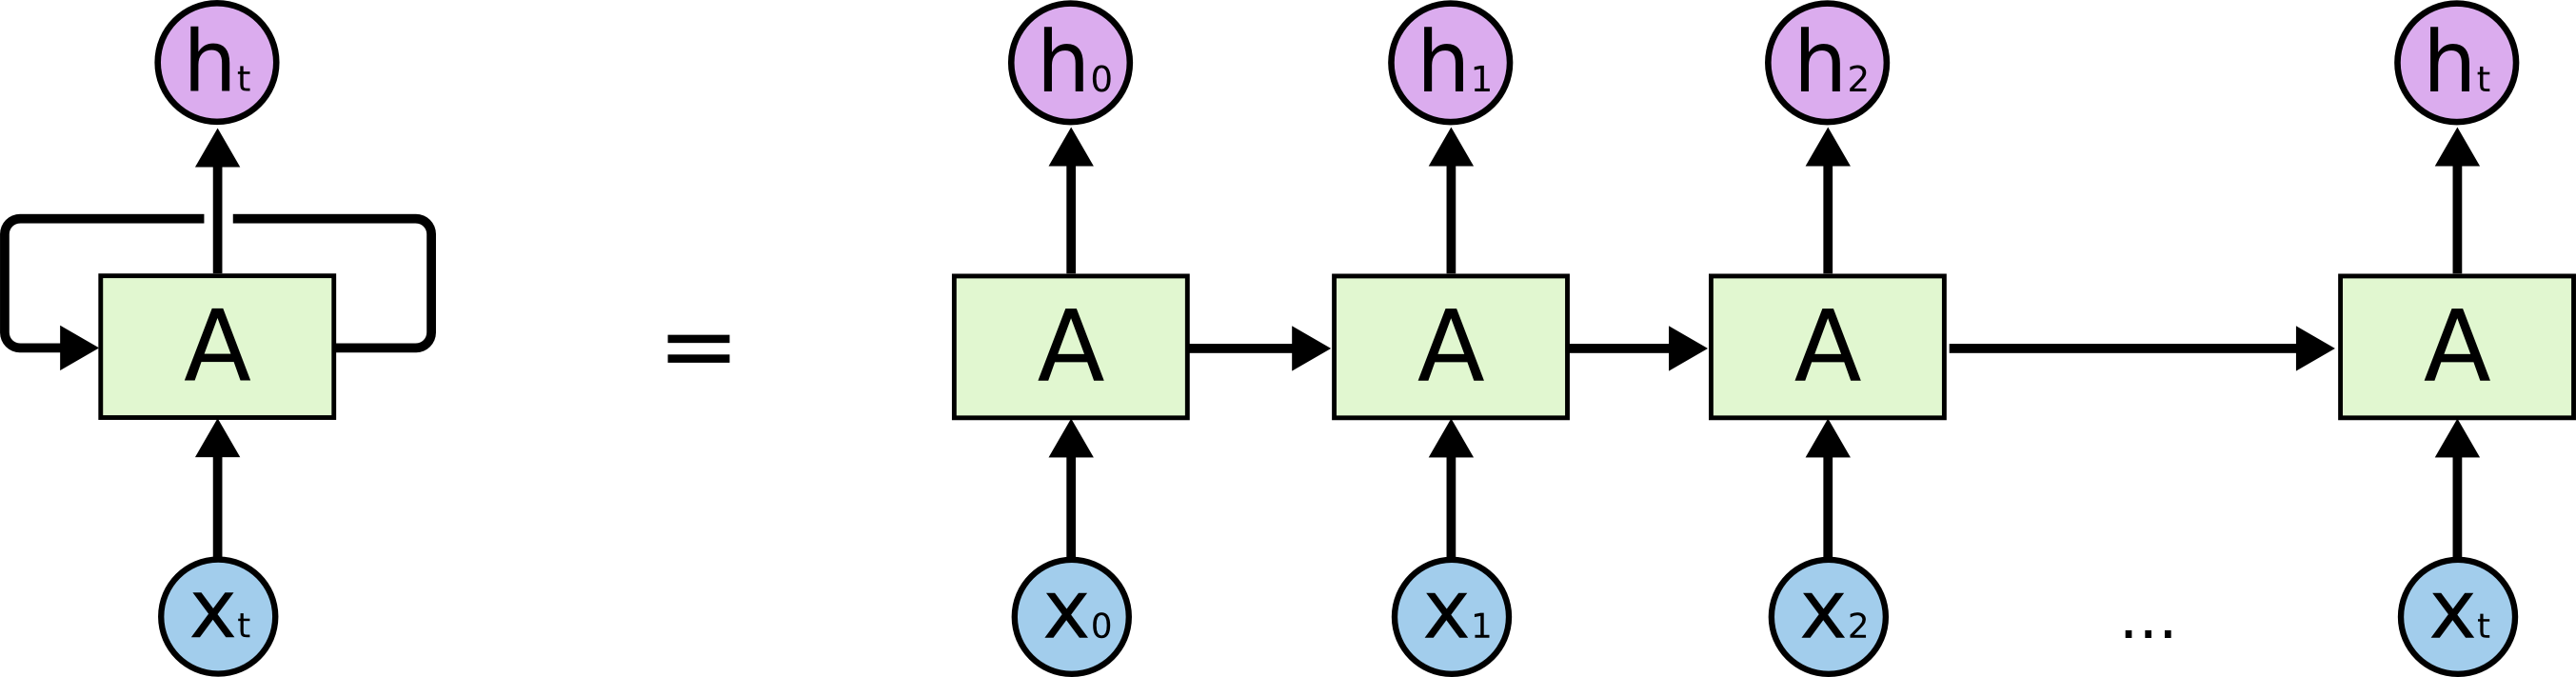

**You would have seen the traditional picture as shown above. But if you take a better look at the bottom, you will be able to create a perfect mind map, something which you will never forget.**

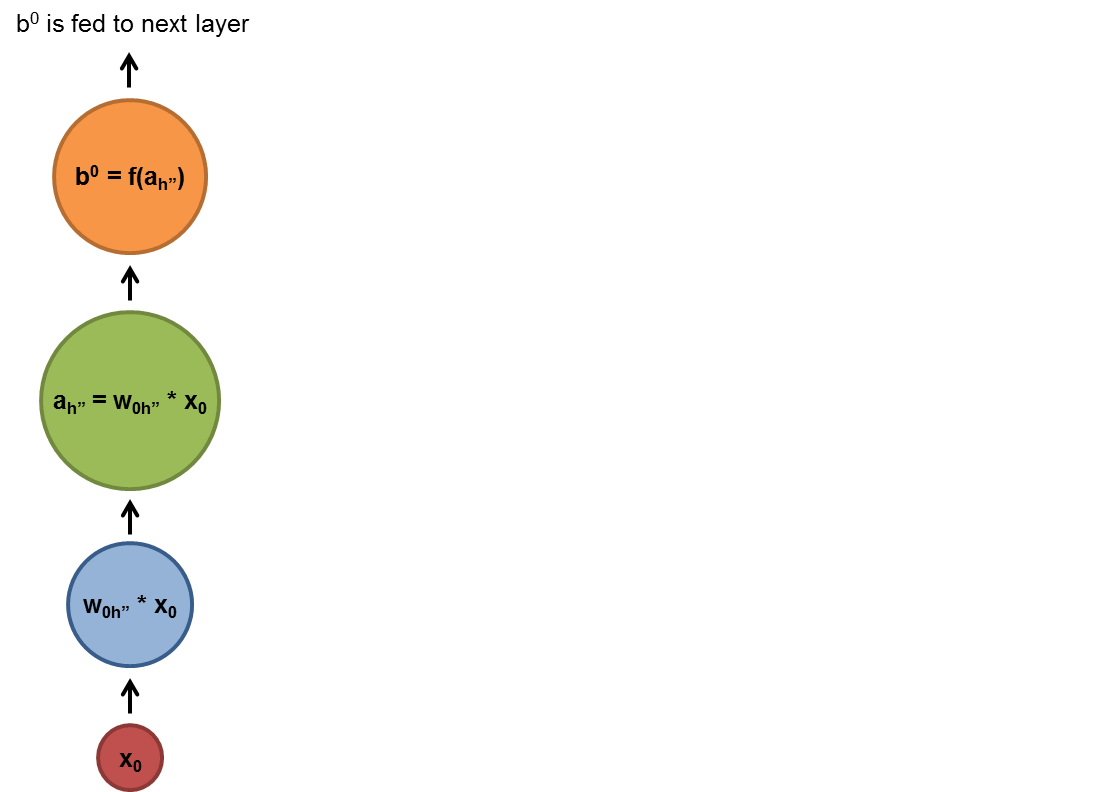

* **Drawbacks of RNNs**: The problem with RNNs is that as time passes by and they get fed more and more new data, they start to “forget” about the previous data they have seen, as it gets diluted between the new data, the transformation from activation function, and the weight multiplication. This means they have a good short term memory, but a slight problem when trying to remember things that have happened a while ago (data they have seen many time steps in the past).

## Solution: 

To overcome this short coming, we need some sort of Long-term memory, which is just what **LSTM**s provide. LSTMs consists of **three gates** than enhances the memory of classical RNNs, therefore storing(remembering) and accessing necessary information with ease.

* Read more about LSTMs here: https://www.kdnuggets.com/2019/08/deep-learning-nlp-explained.html

### Enough of Theory, let's build our very own LSTM Model.

Set Random Seed

Permutation Importance

Learning rate scheduler

Keras Tuner

### The model architecture is as follows:

1) **Embedding Layer** for generating the Embedding Vector for each input sequence.

2) **Conv1D** Layer for convolving data into smaller feature vectors.

3) **LSTM** to improve memory efficiency of RNNs.

4) **Dense** for creating fully Connected Layers for classification

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

You can tweak the parameters and number of layers.

#### From performing a **checkpoint** to an early stop, the **Callbacks** API presents useful methods while training our model. Today, let’s focus on just some of them:

1. **EarlyStopping** — Stop training when a definite metric no longer improves. It works mainly with three parameters: 

----- **monitor** ---> Defines what we are monitoring and, based on that, we will interrupt our training

----- **patience** ---> The number of epochs when we allow our training to continue running without modification before stopping

----- **mode** ---> The mode is how we are monitoring: the maximum value? The minimal? You define here.

2. **LearningRateScheduler** — The learning rate will be modified whenever a new epoch starts (based on a function).

3. **ReduceLROnPlateau** — Reduces the learning rate when a metric has stopped improving. This callback **monitors** a quantity and if no improvement is seen for a **patience** number of epochs, the learning rate is reduced by **factor** value (new_lr = lr * factor).

4. **ModelCheckpoint** — Saves a copy of the model or its weights for later use. (Saving the best version of your model after a single training)

5. **TensorBoard** — Enables TensorBoard when a model is training, saving its logs.

6. **CSVLogger** (Optional) - CSVLogger is a callback that streams epoch results to a CSV file. (creates a csv file that contains info aboutt train_accuracy,loss, and val_accuracy,loss.

### ReduceLROnPlateau vs EarlyStopping:

* ReduceLROnPlateau works like EarlyStopping, with three parameters: monitor, patience, and mode; The difference here occurs with two extra parameters: **min_lr** and **min_delta**; 

* The first is the lowest value for the learning rate, 0.001 is the default value; The other is the value that explains how much the new learning rate will be modified

In [ ]:
## Early Stopping object:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,mode="auto")

## Model Checkpoint Object:
checkpoint_path = 'model_checkpoints/'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

## Automatic learning rate update:
#monitor='val_loss' to use validation loss as performance measure to reduce the learning rate. 
#patience=2 means the learning rate is reduced as soon as 2 epochs with no improvement. 
#min_delta=0.001 means the validation loss has to improve by at least 0.001 for it to count as an improvement. 
#factor=0.2 means the new learning rate will be reduced as new_lr = lr * factor

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=2
)

## Import the saved model and weights:
new_model = create_model()
new_model.load_weights('model_checkpoints/')